In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

In [3]:
data = np.loadtxt('data/kalman_cartesian_data.dat')
kontrola = np.loadtxt('data/kalman_cartesian_kontrola.dat')

In [7]:
# Surovi podatki
t = data[:,0]
x = data[:,1]
y = data[:,2]
vx = data[:,3]
vy = data[:,4]
ax = data[:,5]
ay = data[:,6]

# Kontrilni podatki
t_kontrola = kontrola[:,0]
x_kontrola = kontrola[:,1]
y_kontrola = kontrola[:,2]
vx_kontrola = kontrola[:,3]
vy_kontrola = kontrola[:,4]

In [8]:
z = np.column_stack((x, y, vx, vy)) # meritve
z_kontrola = np.column_stack((x_kontrola, y_kontrola, vx_kontrola, vy_kontrola))

# Časovni korak
del_t = t[1] - t[0]

# Napake meritev
sigma_xy = 25. # m
sigma_a = 0.05 # m/s^2
sigma_v = 0.01 * np.sqrt(vx**2 + vy**2) # m/s
sigma_v = np.where(sigma_v < 1./3.6, 1./3.6, sigma_v) # m/s Popravimo minimalno napako na 1 km/h

In [92]:
# Kalmanov filter

step_x = 1.
step_v = 1.

x_prior = np.zeros_like(z) # prior estimate za lego in hitrost
x_prior[0] = z[0] # Začetno stanje
P_prior = np.zeros((len(z), len(z[0]), len(z[0]))) # prior estimate za kovariančno matriko
P_prior[0] = np.diag((sigma_xy, sigma_xy, sigma_v[0], sigma_v[0])) # Začetno stanje

x_post = np.zeros_like(z) # post estimate za lego in hitrost
x_post[0] = z[0] # Začetno stanje
P_post = np.zeros((len(z), len(z[0]), len(z[0]))) # post estimate za konariančno matriko
P_post[0] = np.diag((sigma_xy, sigma_xy, sigma_v[0], sigma_v[0])) # Začetno stanje

for i in range(len(z)-1):

    F = np.array([ # Opiše dinamiko
        [1., 0., del_t, 0.],
        [0., 1., 0., del_t],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]
    ])
    Q = np.diag((sigma_a**2 * del_t**4 / 4., sigma_a**2 * del_t**4 / 4., sigma_a**2 * del_t**2, sigma_a**2 * del_t**2))
    R = np.diag((sigma_xy**2, sigma_xy**2, sigma_v[i]**2, sigma_v[i]**2))
    H = np.diag((float(i%step_x == 0.), float(i%step_x == 0.), float(i%step_v == 0.), float(i%step_v == 0.)))
    c = np.array([ax[i]*del_t**2 / 2., ax[i]*del_t**2 / 2., ax[i]*del_t, ay[i]*del_t])

    x_prior[i+1] = np.dot(F, x_post[i]) + c
    P_prior[i+1] = np.dot(F, np.dot(P_post[i], F.T)) + Q

    K = np.dot(np.dot(P_prior[i+1], H.T), np.linalg.inv(np.dot(np.dot(H, P_prior[i+1]), H.T) + R))
    x_post[i+1] = x_prior[i+1] + np.dot(K, (z[i+1] - np.dot(H, x_prior[i+1])))
    P_post[i+1] = np.dot((np.diag((1.,1.,1.,1.)) - np.dot(K, H)), P_prior[i+1])

In [24]:
# Kalmanov filter

def kalmanov_filter(step_x, step_v):

    data = np.loadtxt('data/kalman_cartesian_data.dat')
    kontrola = np.loadtxt('data/kalman_cartesian_kontrola.dat')

    # Surovi podatki
    t = data[:,0]
    x = data[:,1]
    y = data[:,2]
    vx = data[:,3]
    vy = data[:,4]
    ax = data[:,5]
    ay = data[:,6]

    # Kontrilni podatki
    t_kontrola = kontrola[:,0]
    x_kontrola = kontrola[:,1]
    y_kontrola = kontrola[:,2]
    vx_kontrola = kontrola[:,3]
    vy_kontrola = kontrola[:,4]

    z = np.column_stack((x, y, vx, vy)) # meritve
    z_kontrola = np.column_stack((x_kontrola, y_kontrola, vx_kontrola, vy_kontrola))
    
    # Časovni korak
    del_t = t[1] - t[0]
    
    # Napake meritev
    sigma_xy = 25. # m
    sigma_a = 0.05 # m/s^2
    sigma_v = 0.01 * np.sqrt(vx**2 + vy**2) # m/s
    sigma_v = np.where(sigma_v < 1./3.6, 1./3.6, sigma_v) # m/s Popravimo minimalno napako na 1 km/h

    x_prior = np.zeros_like(z) # prior estimate za lego in hitrost
    x_prior[0] = z[0] # Začetno stanje
    P_prior = np.zeros((len(z), len(z[0]), len(z[0]))) # prior estimate za kovariančno matriko
    P_prior[0] = np.diag((sigma_xy, sigma_xy, sigma_v[0], sigma_v[0])) # Začetno stanje

    x_post = np.zeros_like(z) # post estimate za lego in hitrost
    x_post[0] = z[0] # Začetno stanje
    P_post = np.zeros((len(z), len(z[0]), len(z[0]))) # post estimate za konariančno matriko
    P_post[0] = np.diag((sigma_xy, sigma_xy, sigma_v[0], sigma_v[0])) # Začetno stanje

    for i in range(len(z)-1):

        F = np.array([ # Opiše dinamiko
            [1., 0., del_t, 0.],
            [0., 1., 0., del_t],
            [0., 0., 1., 0.],
            [0., 0., 0., 1.]
        ])
        Q = np.diag((sigma_a**2 * del_t**4 / 4., sigma_a**2 * del_t**4 / 4., sigma_a**2 * del_t**2, sigma_a**2 * del_t**2))
        R = np.diag((sigma_xy**2, sigma_xy**2, sigma_v[i]**2, sigma_v[i]**2))
        H = np.diag((float(i%step_x == 0.), float(i%step_x == 0.), float(i%step_v == 0.), float(i%step_v == 0.)))
        c = np.array([ax[i]*del_t**2 / 2., ax[i]*del_t**2 / 2., ax[i]*del_t, ay[i]*del_t])

        x_prior[i+1] = np.dot(F, x_post[i]) + c
        P_prior[i+1] = np.dot(F, np.dot(P_post[i], F.T)) + Q

        K = np.dot(np.dot(P_prior[i+1], H.T), np.linalg.inv(np.dot(np.dot(H, P_prior[i+1]), H.T) + R))
        x_post[i+1] = x_prior[i+1] + np.dot(K, (z[i+1] - np.dot(H, x_prior[i+1])))
        P_post[i+1] = np.dot((np.diag((1.,1.,1.,1.)) - np.dot(K, H)), P_prior[i+1])

    return x_prior, x_post, P_prior, P_post

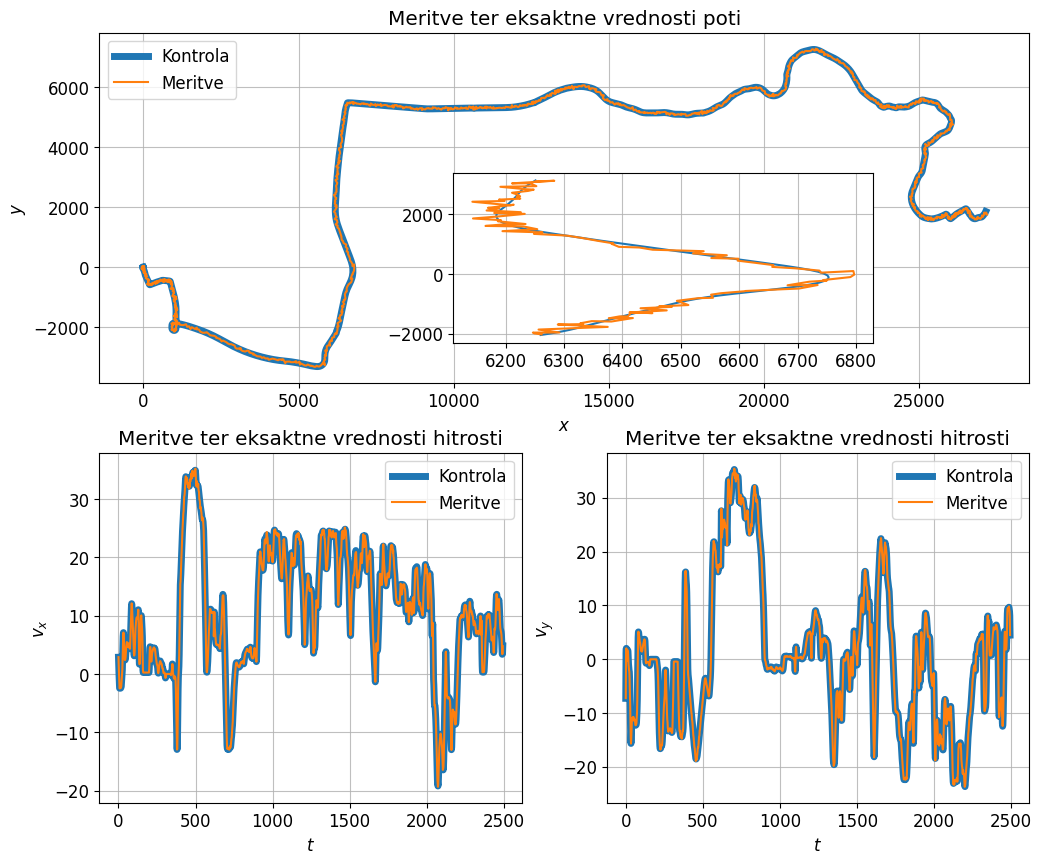

In [234]:
fig = plt.figure(figsize=(12, 10))

ax = fig.add_subplot(2, 2, (1,2))
ax.grid(alpha=0.8)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title('Meritve ter eksaktne vrednosti poti')
ax.plot(z_kontrola[:,0], z_kontrola[:,1], label='Kontrola', linewidth=5)
ax.plot(z[:,0], z[:,1], label='Meritve')
ax.legend()

ax_inset = fig.add_axes([0.42, 0.57, 0.35, 0.17])
ax_inset.grid(alpha=0.8)
ax_inset.plot(z_kontrola[:,0][350:450], z_kontrola[:,1][350:450], label='Kontrola')
ax_inset.plot(z[:,0][350:450], z[:,1][350:450], label='Meritve')

ax = fig.add_subplot(2, 2, 3)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_x$')
ax.set_title('Meritve ter eksaktne vrednosti hitrosti')
ax.plot(t_kontrola, z_kontrola[:,2], label='Kontrola', linewidth=5)
ax.plot(t, z[:,2], label='Meritve')
ax.legend()

ax = fig.add_subplot(2, 2, 4)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_y$')
ax.set_title('Meritve ter eksaktne vrednosti hitrosti')
ax.plot(t_kontrola, z_kontrola[:,3], label='Kontrola', linewidth=5)
ax.plot(t, z[:,3], label='Meritve')
ax.legend()

In [139]:
x_prior11, x_post11, P_prior11, P_post11 = kalmanov_filter(1., 1.)
x_prior105, x_post105, P_prior105, P_post105 = kalmanov_filter(10., 5.)

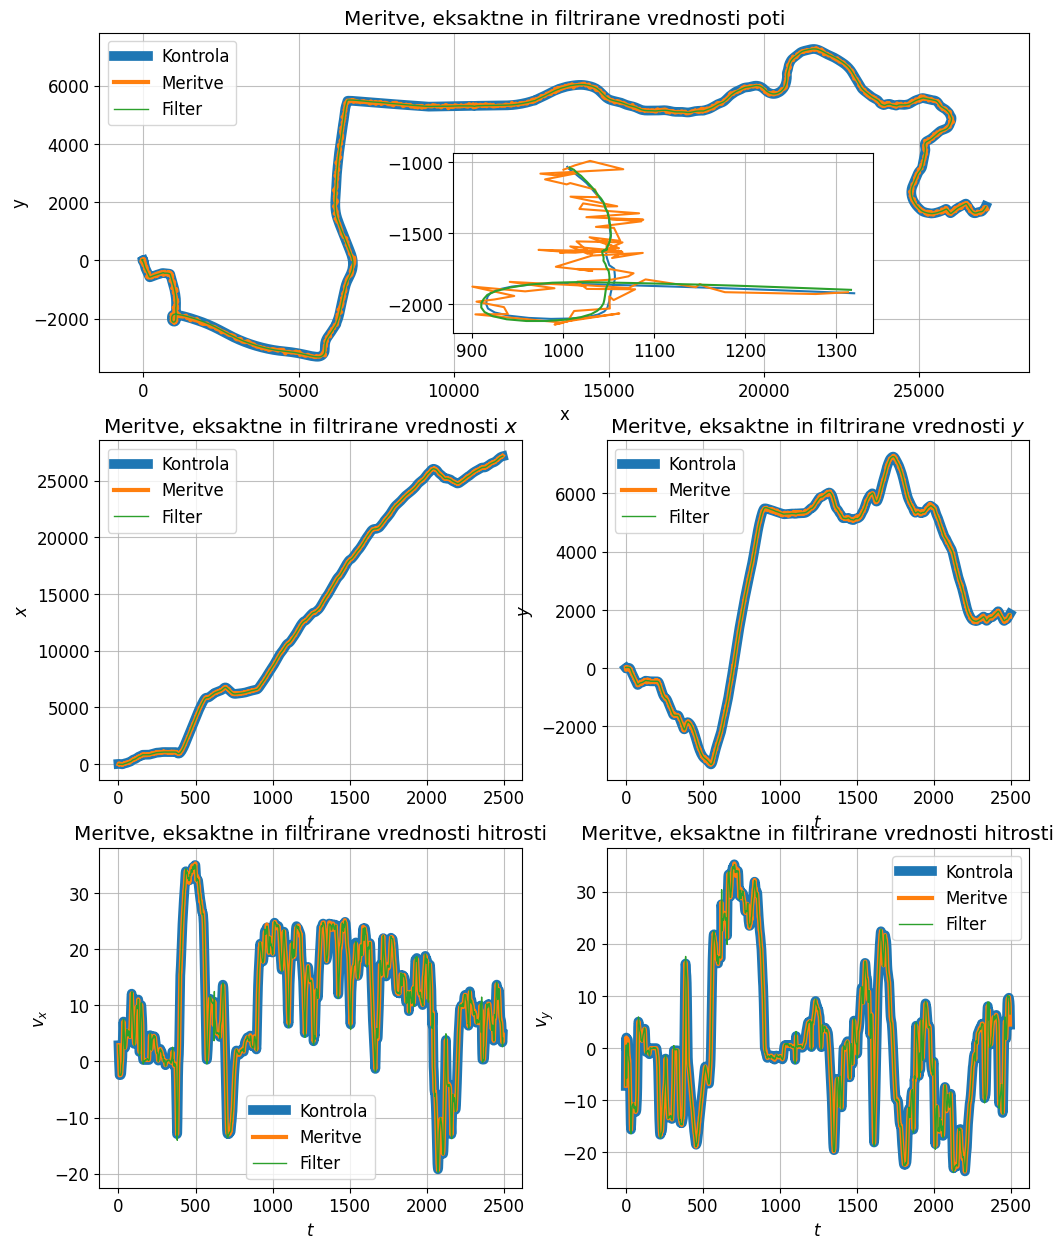

In [229]:
fig = plt.figure(figsize=(12, 15))

ax = fig.add_subplot(3, 2, (1,2))
ax.grid(alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Meritve, eksaktne in filtrirane vrednosti poti')
ax.plot(z_kontrola[:,0], z_kontrola[:,1], label='Kontrola', linewidth=7)
ax.plot(z[:,0], z[:,1], label='Meritve', linewidth=3)
ax.plot(x_post11[:,0], x_post11[:,1], label='Filter', linewidth=1)
ax.legend()

ax_inset = fig.add_axes([0.42, 0.68, 0.35, 0.12])
ax_inset.grid(alpha=0.8)
ax_inset.plot(z_kontrola[:,0][145:235], z_kontrola[:,1][145:235], label='Kontrola')
ax_inset.plot(z[:,0][145:235], z[:,1][145:235], label='Meritve')
ax_inset.plot(x_post11[:,0][145:235], x_post11[:,1][145:235], label='Filter')

ax = fig.add_subplot(3, 2, 3)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_title(r'Meritve, eksaktne in filtrirane vrednosti $x$')
ax.plot(t_kontrola, z_kontrola[:,0], label='Kontrola', linewidth=7)
ax.plot(t, z[:,0], label='Meritve', linewidth=3)
ax.plot(t, x_post11[:,0], label='Filter', linewidth=1)
ax.legend()

ax = fig.add_subplot(3, 2, 4)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$y$')
ax.set_title(r'Meritve, eksaktne in filtrirane vrednosti $y$')
ax.plot(t_kontrola, z_kontrola[:,1], label='Kontrola', linewidth=7)
ax.plot(t, z[:,1], label='Meritve', linewidth=3)
ax.plot(t, x_post11[:,1], label='Filter', linewidth=1)
ax.legend()

ax = fig.add_subplot(3, 2, 5)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_x$')
ax.set_title(r'Meritve, eksaktne in filtrirane vrednosti hitrosti')
ax.plot(t_kontrola, z_kontrola[:,2], label='Kontrola', linewidth=7)
ax.plot(t, z[:,2], label='Meritve', linewidth=3)
ax.plot(t, x_post11[:,2], label='Filter', linewidth=1)
ax.legend()

ax = fig.add_subplot(3, 2, 6)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_y$')
ax.set_title(r'Meritve, eksaktne in filtrirane vrednosti hitrosti')
ax.plot(t_kontrola, z_kontrola[:,3], label='Kontrola', linewidth=7)
ax.plot(t, z[:,3], label='Meritve', linewidth=3)
ax.plot(t, x_post11[:,3], label='Filter', linewidth=1)
ax.legend()

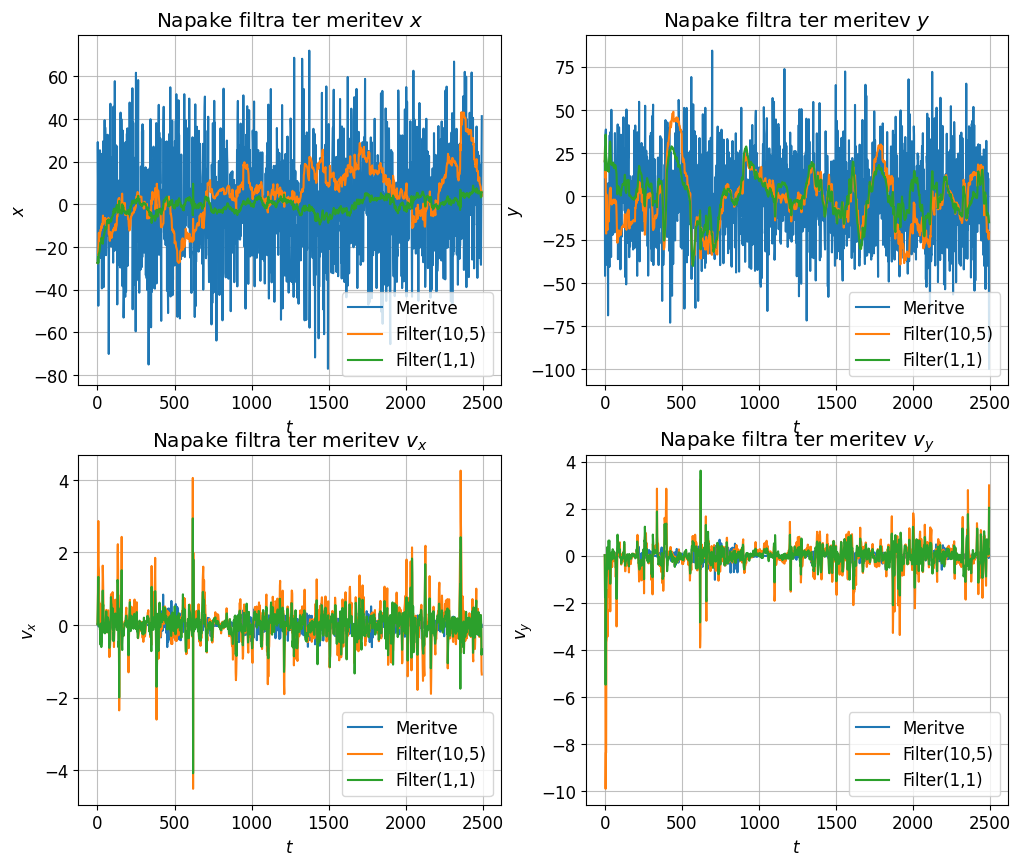

In [178]:
fig = plt.figure(figsize=(12, 10))

ax = fig.add_subplot(2, 2, 1)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_title(r'Napake filtra ter meritev $x$')
ax.plot(t, z[:,0]-z_kontrola[:,0], label='Meritve')
ax.plot(t, x_post105[:,0]-z_kontrola[:,0], label='Filter(10,5)')
ax.plot(t, x_post11[:,0]-z_kontrola[:,0], label='Filter(1,1)')
ax.legend()

ax = fig.add_subplot(2, 2, 2)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$y$')
ax.set_title(r'Napake filtra ter meritev $y$')
ax.plot(t, z[:,1] - z_kontrola[:,1], label='Meritve')
ax.plot(t, x_post105[:,1] - z_kontrola[:,1], label='Filter(10,5)')
ax.plot(t, x_post11[:,1] - z_kontrola[:,1], label='Filter(1,1)')
ax.legend()

ax = fig.add_subplot(2, 2, 3)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_x$')
ax.set_title(r'Napake filtra ter meritev $v_x$')
ax.plot(t, z[:,2] - z_kontrola[:,2], label='Meritve')
ax.plot(t, x_post105[:,2] - z_kontrola[:,2], label='Filter(10,5)')
ax.plot(t, x_post11[:,2] - z_kontrola[:,2], label='Filter(1,1)')
ax.legend()

ax = fig.add_subplot(2, 2, 4)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_y$')
ax.set_title(r'Napake filtra ter meritev $v_y$')
ax.plot(t, z[:,3] - z_kontrola[:,3], label='Meritve')
ax.plot(t, x_post105[:,3] - z_kontrola[:,3], label='Filter(10,5)')
ax.plot(t, x_post11[:,3] - z_kontrola[:,3], label='Filter(1,1)')
ax.legend()

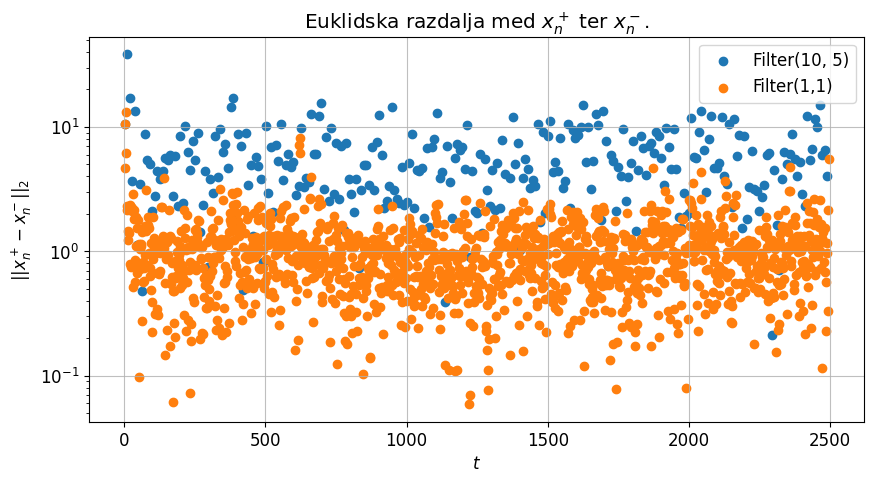

In [191]:
# Euclidska razdalja med x_prior, x_post

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.set_title(r'Euklidska razdalja med $x_n^+$ ter $x_n^-$.')
ax.set_ylabel(r'$||x_n^+ - x_n^-||_2$')
ax.set_xlabel(r'$t$')
ax.grid(alpha=0.8)
ax.scatter(t, np.linalg.norm(x_post105-x_prior105, axis=1), label='Filter(10, 5)')
ax.scatter(t, np.linalg.norm(x_post11-x_prior11, axis=1), label='Filter(1,1)')
ax.set_yscale('log')
ax.legend()

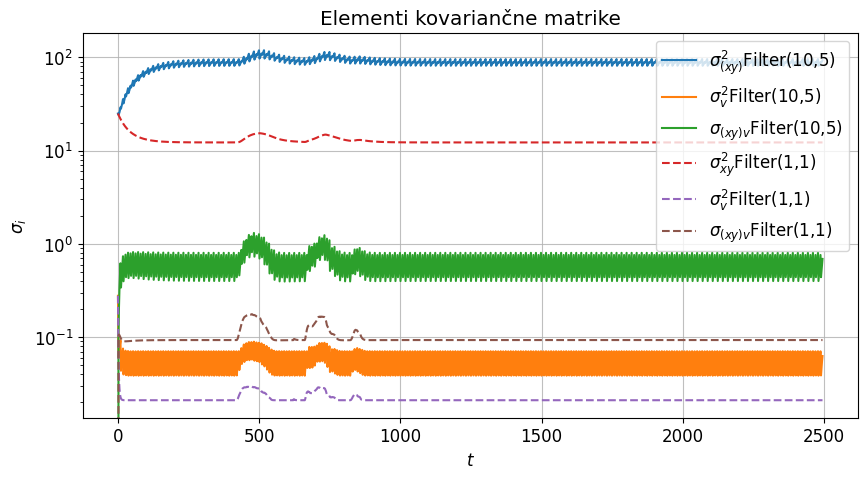

In [216]:
# Kovariančna matrika

sig_xy105 = P_post105[:,0,0]
sig_v105 = P_post105[:,2,2]
sig_vxy105 = P_post105[:,1,3]
sig_xy11 = P_post11[:,0,0]
sig_v11 = P_post11[:,2,2]
sig_vxy11 = P_post11[:,1,3]

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.set_title(r'Elementi kovariančne matrike')
ax.set_ylabel(r'$\sigma_{i}$')
ax.set_xlabel(r'$t$')
ax.grid(alpha=0.8)
ax.plot(t, sig_xy105, label=r'$\sigma_{(xy)}^2$Filter(10,5)')
ax.plot(t, sig_v105, label=r'$\sigma_{v}^2$Filter(10,5)')
ax.plot(t, sig_vxy105, label=r'$\sigma_{(xy)v}$Filter(10,5)')
ax.plot(t, sig_xy11, label=r'$\sigma_{xy}^2$Filter(1,1)', ls='--')
ax.plot(t, sig_v11, label=r'$\sigma_{v}^2$Filter(1,1)', ls='--')
ax.plot(t, sig_vxy11, label=r'$\sigma_{(xy)v}$Filter(1,1)', ls='--')
ax.set_yscale('log')
ax.legend()

In [236]:
# RMSE v odvisnosti od korakov

steps_x = np.array([1, 2, 5, 10, 25, 50, 100])
steps_v = np.array([1, 2, 5, 10, 25, 50, 100])

RMSE_x = np.zeros((len(steps_x), len(steps_v)))
RMSE_y = np.zeros((len(steps_x), len(steps_v)))
RMSE_vx = np.zeros((len(steps_x), len(steps_v)))
RMSE_vy = np.zeros((len(steps_x), len(steps_v)))

for i, step_x in enumerate(steps_x):

    print(step_x)

    for j, step_v in enumerate(steps_v):

        x_prior, x_post, P_prior, P_post = kalmanov_filter(step_x, step_v)

        RMSE_x[i][j] =  np.sqrt(np.mean((x_post[:,0]-z_kontrola[:,0])**2))
        RMSE_y[i][j] =  np.sqrt(np.mean((x_post[:,1]-z_kontrola[:,1])**2))
        RMSE_vx[i][j] =  np.sqrt(np.mean((x_post[:,2]-z_kontrola[:,2])**2))
        RMSE_vy[i][j] =  np.sqrt(np.mean((x_post[:,3]-z_kontrola[:,3])**2))

1
2
5
10
25
50
100


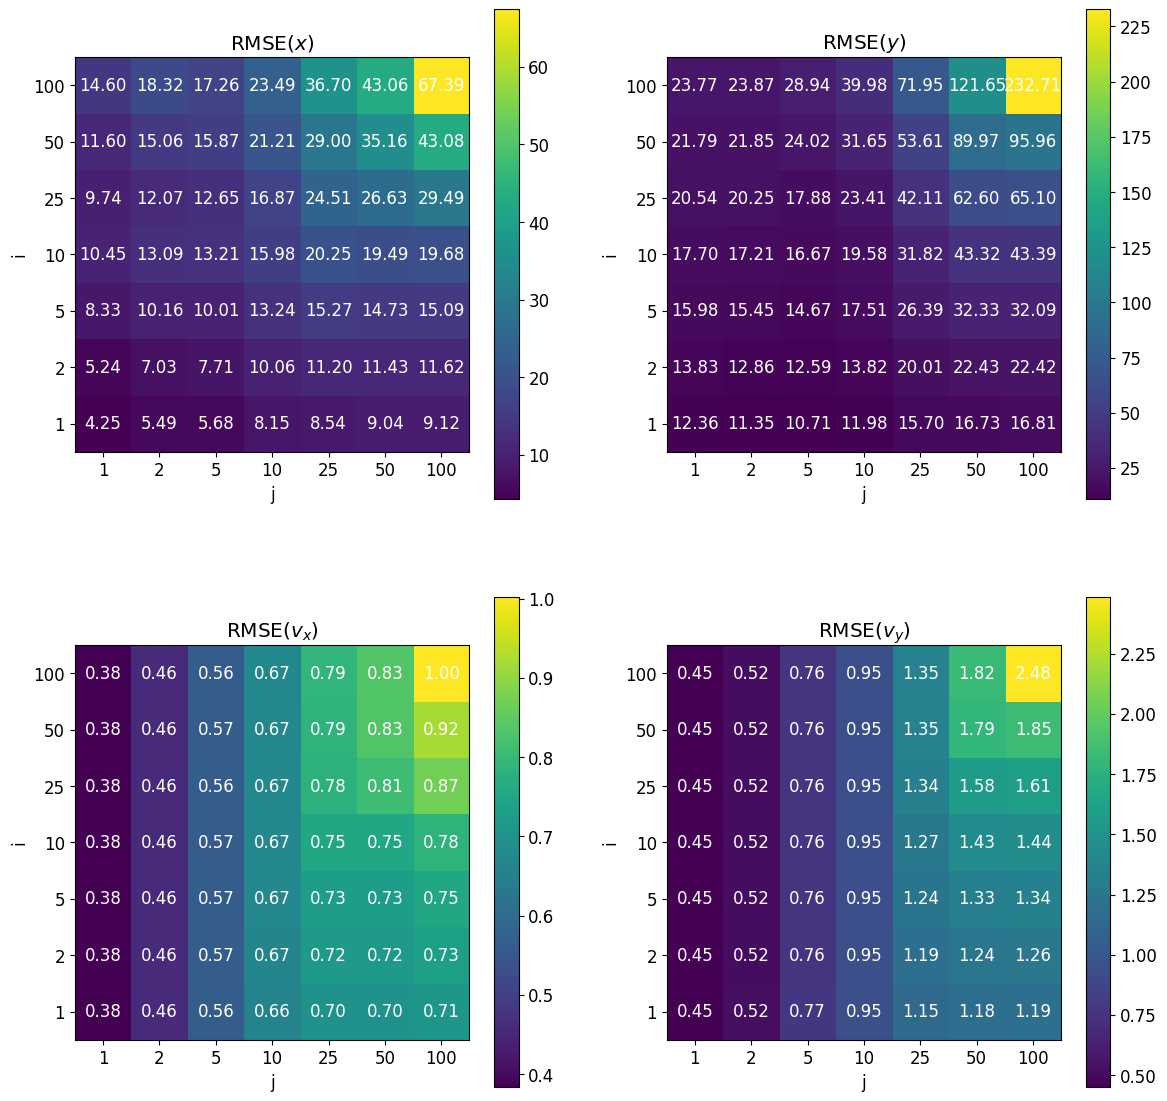

In [257]:
fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(2, 2, 1)  # Corrected the method name from add_subfigure to add_subplot

im = ax.imshow(RMSE_x)
ax.set_xticks(np.arange(len(steps_v)))
ax.set_yticks(np.arange(len(steps_x)))
ax.set_xticklabels(steps_v)
ax.set_yticklabels(steps_x)
ax.invert_yaxis()  # Invert the y-axis

# Adding annotations with values
for i in range(len(steps_x)):
    for j in range(len(steps_v)):
        color = 'white'
        ax.text(j, i, f'{RMSE_x[i, j]:.2f}', ha='center', va='center', color=color)

# Adding labels and title
ax.set_title(r'RMSE($x$)')
ax.set_ylabel(r'i')
ax.set_xlabel(r'j')

# Adding colorbar
cbar = ax.figure.colorbar(im, ax=ax)


ax = fig.add_subplot(2, 2, 2)  # Corrected the method name from add_subfigure to add_subplot

im = ax.imshow(RMSE_y)
ax.set_xticks(np.arange(len(steps_v)))
ax.set_yticks(np.arange(len(steps_x)))
ax.set_xticklabels(steps_v)
ax.set_yticklabels(steps_x)
ax.invert_yaxis()  # Invert the y-axis

# Adding annotations with values
for i in range(len(steps_x)):
    for j in range(len(steps_v)):
        color = 'white'
        ax.text(j, i, f'{RMSE_y[i, j]:.2f}', ha='center', va='center', color=color)

# Adding labels and title
ax.set_title(r'RMSE($y$)')
ax.set_ylabel(r'i')
ax.set_xlabel(r'j')

# Adding colorbar
cbar = ax.figure.colorbar(im, ax=ax)


ax = fig.add_subplot(2, 2, 3)  # Corrected the method name from add_subfigure to add_subplot

im = ax.imshow(RMSE_vx)
ax.set_xticks(np.arange(len(steps_v)))
ax.set_yticks(np.arange(len(steps_x)))
ax.set_xticklabels(steps_v)
ax.set_yticklabels(steps_x)
ax.invert_yaxis()  # Invert the y-axis

# Adding annotations with values
for i in range(len(steps_x)):
    for j in range(len(steps_v)):
        color = 'white'
        ax.text(j, i, f'{RMSE_vx[i, j]:.2f}', ha='center', va='center', color=color)

# Adding labels and title
ax.set_title(r'RMSE($v_x$)')
ax.set_ylabel(r'i')
ax.set_xlabel(r'j')

# Adding colorbar
cbar = ax.figure.colorbar(im, ax=ax)


ax = fig.add_subplot(2, 2, 4)  # Corrected the method name from add_subfigure to add_subplot

im = ax.imshow(RMSE_vy)
ax.set_xticks(np.arange(len(steps_v)))
ax.set_yticks(np.arange(len(steps_x)))
ax.set_xticklabels(steps_v)
ax.set_yticklabels(steps_x)
ax.invert_yaxis()  # Invert the y-axis

# Adding annotations with values
for i in range(len(steps_x)):
    for j in range(len(steps_v)):
        color = 'white'
        ax.text(j, i, f'{RMSE_vy[i, j]:.2f}', ha='center', va='center', color=color)

# Adding labels and title
ax.set_title(r'RMSE($v_y$)')
ax.set_ylabel(r'i')
ax.set_xlabel(r'j')

# Adding colorbar
cbar = ax.figure.colorbar(im, ax=ax)

plt.show()


In [25]:
# Kalman brez hitrosti

x_prior_v, x_post_v, P_prior_v, P_post_v = kalmanov_filter(1, 100000000)
x_prior_x, x_post_x, P_prior_x, P_post_x = kalmanov_filter(100000000, 1)

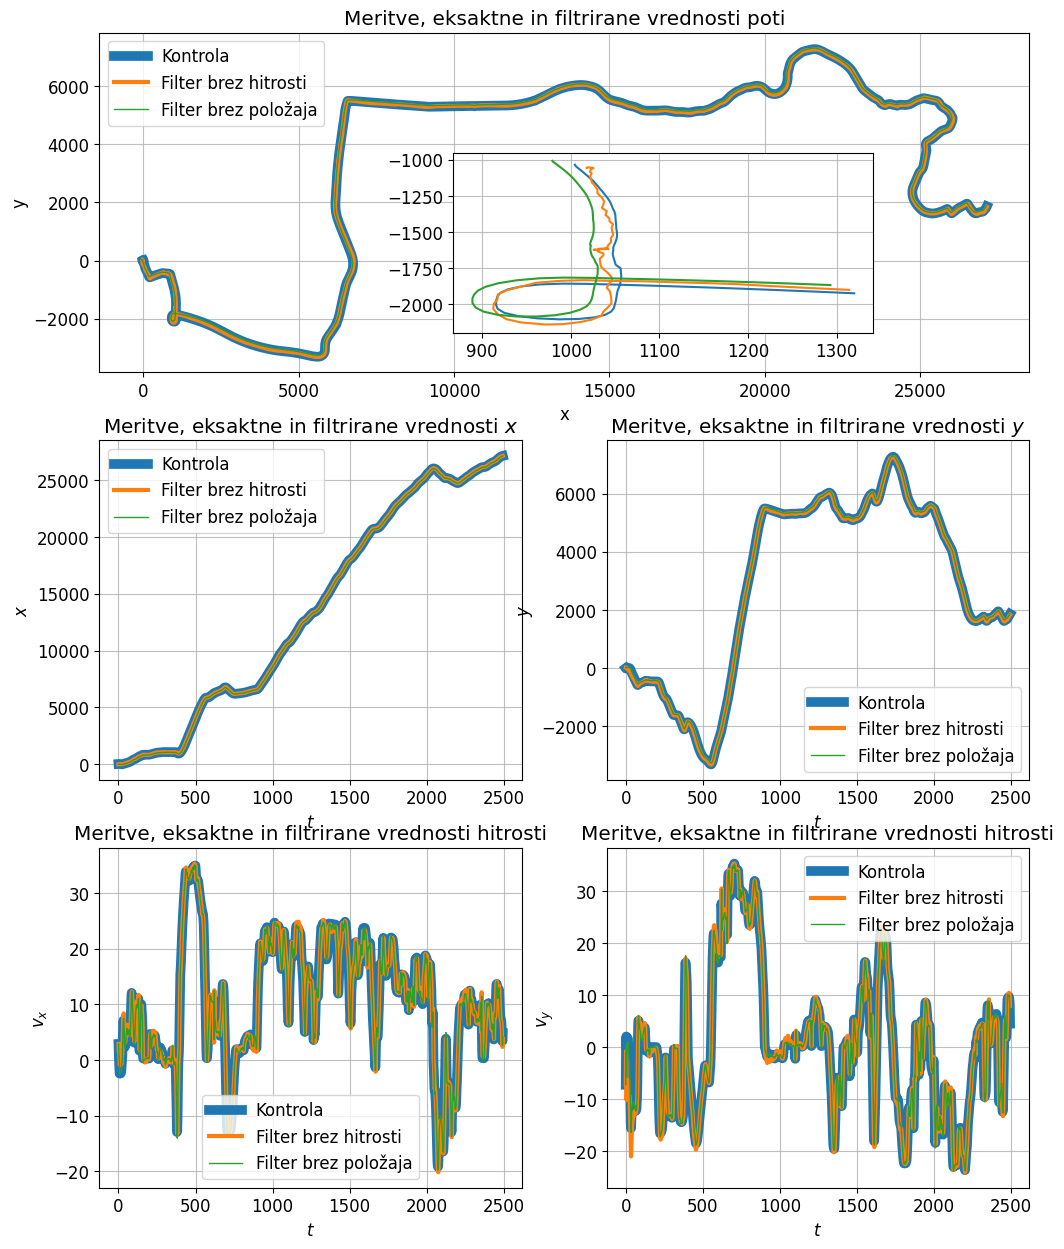

In [27]:
fig = plt.figure(figsize=(12, 15))

ax = fig.add_subplot(3, 2, (1,2))
ax.grid(alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Meritve, eksaktne in filtrirane vrednosti poti')
ax.plot(z_kontrola[:,0], z_kontrola[:,1], label='Kontrola', linewidth=7)
ax.plot(x_post_v[:,0], x_post_v[:,1], label='Filter brez hitrosti', linewidth=3)
ax.plot(x_post_x[:,0], x_post_x[:,1], label='Filter brez položaja', linewidth=1)
ax.legend()

ax_inset = fig.add_axes([0.42, 0.68, 0.35, 0.12])
ax_inset.grid(alpha=0.8)
ax_inset.plot(z_kontrola[:,0][145:235], z_kontrola[:,1][145:235], label='Kontrola')
ax_inset.plot(x_post_v[:,0][145:235], x_post_v[:,1][145:235], label='Filter brez hitrosti')
ax_inset.plot(x_post_x[:,0][145:235], x_post_x[:,1][145:235], label='Filter brez položaja')

ax = fig.add_subplot(3, 2, 3)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_title(r'Meritve, eksaktne in filtrirane vrednosti $x$')
ax.plot(t_kontrola, z_kontrola[:,0], label='Kontrola', linewidth=7)
ax.plot(t, x_post_v[:,0], label='Filter brez hitrosti', linewidth=3)
ax.plot(t, x_post_x[:,0], label='Filter brez položaja', linewidth=1)
ax.legend()

ax = fig.add_subplot(3, 2, 4)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$y$')
ax.set_title(r'Meritve, eksaktne in filtrirane vrednosti $y$')
ax.plot(t_kontrola, z_kontrola[:,1], label='Kontrola', linewidth=7)
ax.plot(t, x_post_v[:,1], label='Filter brez hitrosti', linewidth=3)
ax.plot(t, x_post_x[:,1], label='Filter brez položaja', linewidth=1)
ax.legend()

ax = fig.add_subplot(3, 2, 5)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_x$')
ax.set_title(r'Meritve, eksaktne in filtrirane vrednosti hitrosti')
ax.plot(t_kontrola, z_kontrola[:,2], label='Kontrola', linewidth=7)
ax.plot(t, x_post_v[:,2], label='Filter brez hitrosti', linewidth=3)
ax.plot(t, x_post_x[:,2], label='Filter brez položaja', linewidth=1)
ax.legend()

ax = fig.add_subplot(3, 2, 6)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_y$')
ax.set_title(r'Meritve, eksaktne in filtrirane vrednosti hitrosti')
ax.plot(t_kontrola, z_kontrola[:,3], label='Kontrola', linewidth=7)
ax.plot(t, x_post_v[:,3], label='Filter brez hitrosti', linewidth=3)
ax.plot(t, x_post_x[:,3], label='Filter brez položaja', linewidth=1)
ax.legend()

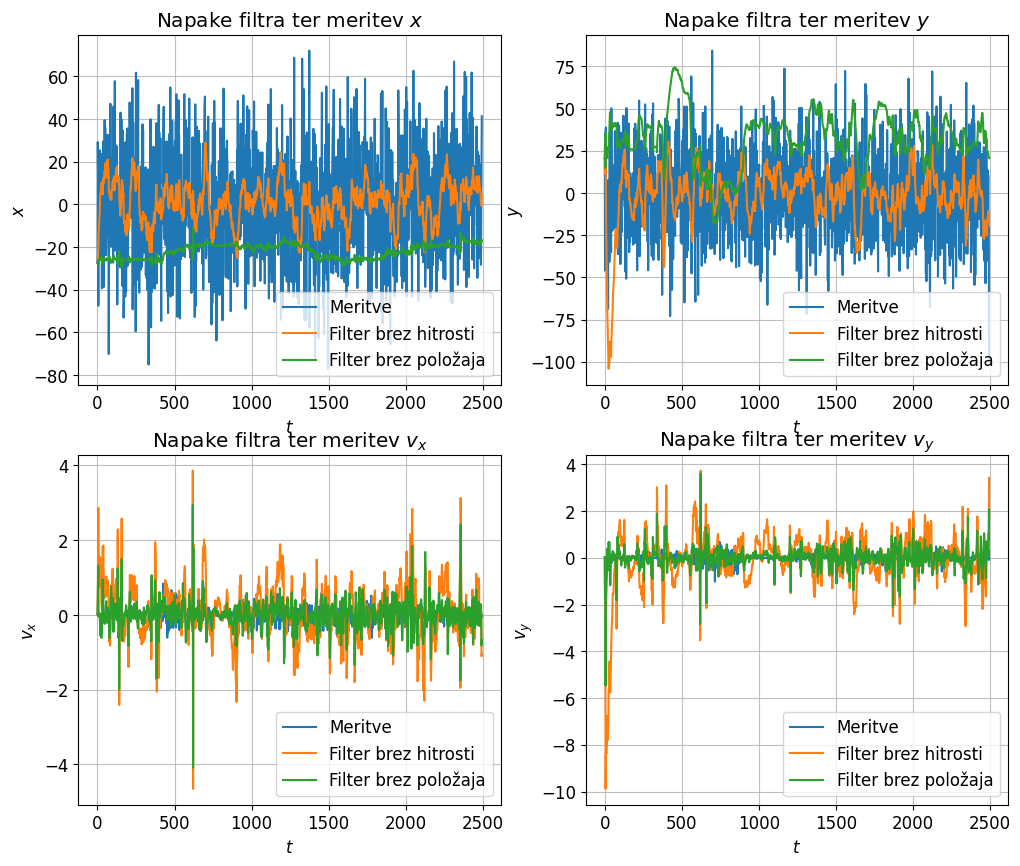

In [29]:
fig = plt.figure(figsize=(12, 10))

ax = fig.add_subplot(2, 2, 1)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_title(r'Napake filtra ter meritev $x$')
ax.plot(t, z[:,0]-z_kontrola[:,0], label='Meritve')
ax.plot(t, x_post_v[:,0]-z_kontrola[:,0], label='Filter brez hitrosti')
ax.plot(t, x_post_x[:,0]-z_kontrola[:,0], label='Filter brez položaja')
ax.legend()

ax = fig.add_subplot(2, 2, 2)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$y$')
ax.set_title(r'Napake filtra ter meritev $y$')
ax.plot(t, z[:,1] - z_kontrola[:,1], label='Meritve')
ax.plot(t, x_post_v[:,1] - z_kontrola[:,1], label='Filter brez hitrosti')
ax.plot(t, x_post_x[:,1] - z_kontrola[:,1], label='Filter brez položaja')
ax.legend()

ax = fig.add_subplot(2, 2, 3)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_x$')
ax.set_title(r'Napake filtra ter meritev $v_x$')
ax.plot(t, z[:,2] - z_kontrola[:,2], label='Meritve')
ax.plot(t, x_post_v[:,2] - z_kontrola[:,2], label='Filter brez hitrosti')
ax.plot(t, x_post_x[:,2] - z_kontrola[:,2], label='Filter brez položaja')
ax.legend()

ax = fig.add_subplot(2, 2, 4)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_y$')
ax.set_title(r'Napake filtra ter meritev $v_y$')
ax.plot(t, z[:,3] - z_kontrola[:,3], label='Meritve')
ax.plot(t, x_post_v[:,3] - z_kontrola[:,3], label='Filter brez hitrosti')
ax.plot(t, x_post_x[:,3] - z_kontrola[:,3], label='Filter brez položaja')
ax.legend()

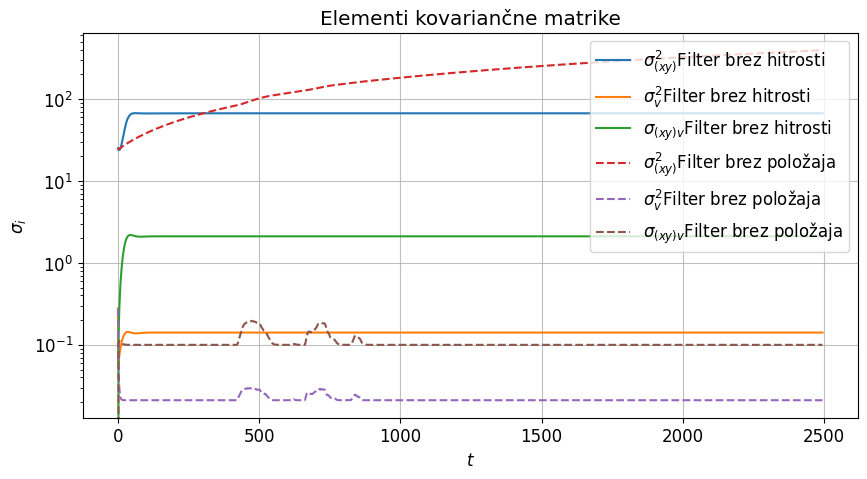

In [30]:
# Kovariančna matrika

sig_xy_v = P_post_v[:,0,0]
sig_v_v = P_post_v[:,2,2]
sig_vxy_v = P_post_v[:,1,3]
sig_xy_x = P_post_x[:,0,0]
sig_v_x= P_post_x[:,2,2]
sig_vxy_x = P_post_x[:,1,3]

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.set_title(r'Elementi kovariančne matrike')
ax.set_ylabel(r'$\sigma_{i}$')
ax.set_xlabel(r'$t$')
ax.grid(alpha=0.8)
ax.plot(t, sig_xy_v, label=r'$\sigma_{(xy)}^2$Filter brez hitrosti')
ax.plot(t, sig_v_v, label=r'$\sigma_{v}^2$Filter brez hitrosti')
ax.plot(t, sig_vxy_v, label=r'$\sigma_{(xy)v}$Filter brez hitrosti')
ax.plot(t, sig_xy_x, label=r'$\sigma_{(xy)}^2$Filter brez položaja', ls='--')
ax.plot(t, sig_v_x, label=r'$\sigma_{v}^2$Filter brez položaja', ls='--')
ax.plot(t, sig_vxy_x, label=r'$\sigma_{(xy)v}$Filter brez položaja', ls='--')
ax.set_yscale('log')
ax.legend(loc='upper right')

In [37]:
# RMSE v odvisnosti od korakov

steps = np.linspace(1, 100, 100)

RMSE_x_v = np.zeros(len(steps))
RMSE_y_v = np.zeros(len(steps))
RMSE_vx_v = np.zeros(len(steps))
RMSE_vy_v = np.zeros(len(steps))
RMSE_x_x = np.zeros(len(steps))
RMSE_y_x = np.zeros(len(steps))
RMSE_vx_x = np.zeros(len(steps))
RMSE_vy_x = np.zeros(len(steps))

for i, step in enumerate(steps):

    print(step)

    x_prior_v, x_post_v, P_prior_v, P_post_v = kalmanov_filter(step, 100000000)
    x_prior_x, x_post_x, P_prior_x, P_post_x = kalmanov_filter(100000000, step)

    RMSE_x_v[i] =  np.sqrt(np.mean((x_post_v[:,0]-z_kontrola[:,0])**2))
    RMSE_y_v[i] =  np.sqrt(np.mean((x_post_v[:,1]-z_kontrola[:,1])**2))
    RMSE_vx_v[i] =  np.sqrt(np.mean((x_post_v[:,2]-z_kontrola[:,2])**2))
    RMSE_vy_v[i] =  np.sqrt(np.mean((x_post_v[:,3]-z_kontrola[:,3])**2))
    RMSE_x_x[i] =  np.sqrt(np.mean((x_post_x[:,0]-z_kontrola[:,0])**2))
    RMSE_y_x[i] =  np.sqrt(np.mean((x_post_x[:,1]-z_kontrola[:,1])**2))
    RMSE_vx_x[i] =  np.sqrt(np.mean((x_post_x[:,2]-z_kontrola[:,2])**2))
    RMSE_vy_x[i] =  np.sqrt(np.mean((x_post_x[:,3]-z_kontrola[:,3])**2))

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0


In [36]:
print(RMSE_x_x)

[22.12117304 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304
 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304
 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304
 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304
 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304
 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304
 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304
 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304
 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304
 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304
 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304
 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304
 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304 22.12117304
 22.12117304 22.12117304 22.12117304 22.12117304 22

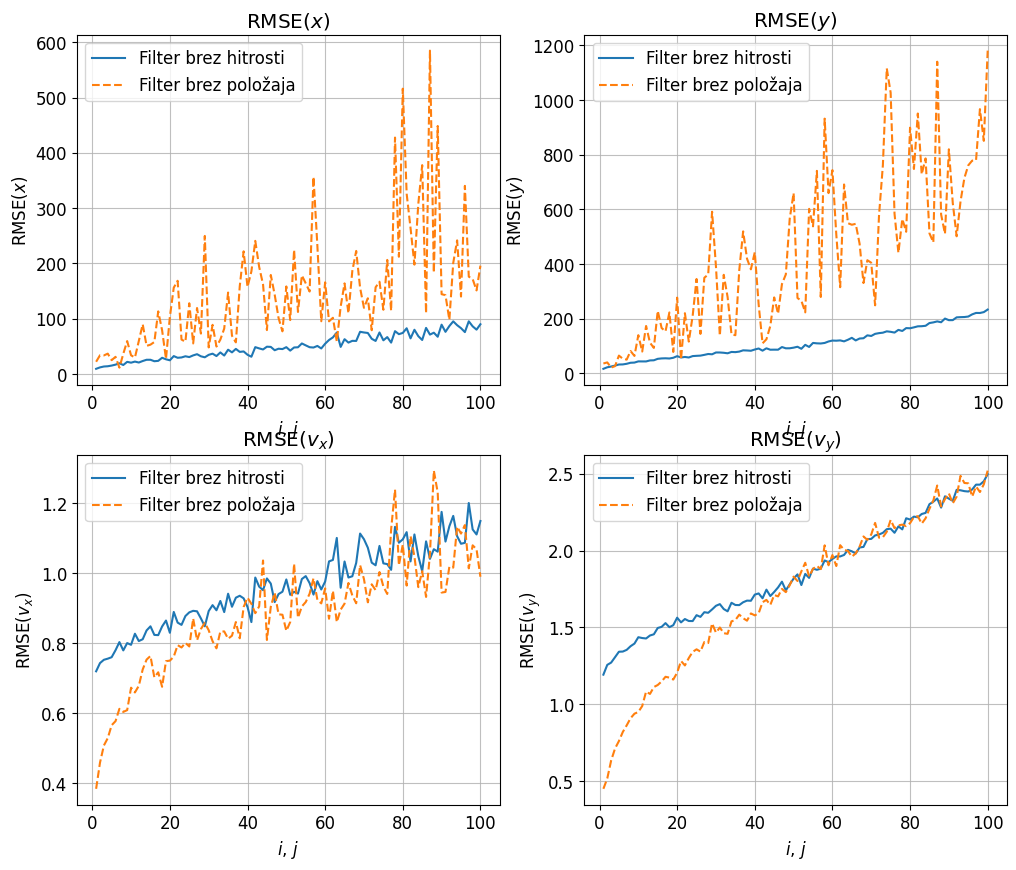

In [39]:
fig = plt.figure(figsize=(12, 10))

ax = fig.add_subplot(2, 2, 1)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$i$, $j$')
ax.set_ylabel(r'RMSE($x$)')
ax.set_title(r'RMSE$(x)$')
ax.plot(steps, RMSE_x_v, label='Filter brez hitrosti')
ax.plot(steps, RMSE_x_x, label='Filter brez položaja', ls='--')
ax.legend()

ax = fig.add_subplot(2, 2, 2)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$i$, $j$')
ax.set_ylabel(r'RMSE($y$)')
ax.set_title(r'RMSE$(y)$')
ax.plot(steps, RMSE_y_v, label='Filter brez hitrosti')
ax.plot(steps, RMSE_y_x, label='Filter brez položaja', ls='--')
ax.legend()

ax = fig.add_subplot(2, 2, 3)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$i$, $j$')
ax.set_ylabel(r'RMSE($v_x)$')
ax.set_title(r'RMSE$(v_x)$')
ax.plot(steps, RMSE_vx_v, label='Filter brez hitrosti')
ax.plot(steps, RMSE_vx_x, label='Filter brez položaja', ls='--')
ax.legend()

ax = fig.add_subplot(2, 2, 4)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$i$, $j$')
ax.set_ylabel(r'RMSE($v_y)$')
ax.set_title(r'RMSE$(v_y)$')
ax.plot(steps, RMSE_vy_v, label='Filter brez hitrosti')
ax.plot(steps, RMSE_vy_x, label='Filter brez položaja', ls='--')
ax.legend()